In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import tqdm
import pickle
import time

from swimAD2 import swimAD2 as ad2       # copy swimAD2.py to your working directory
import dwfconstants as dwfc

ad2.disconnect()            # close all instances before connecting
zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

8192 81920.0
10.0 -33.0 0.6818181818181818
8192 81920.0


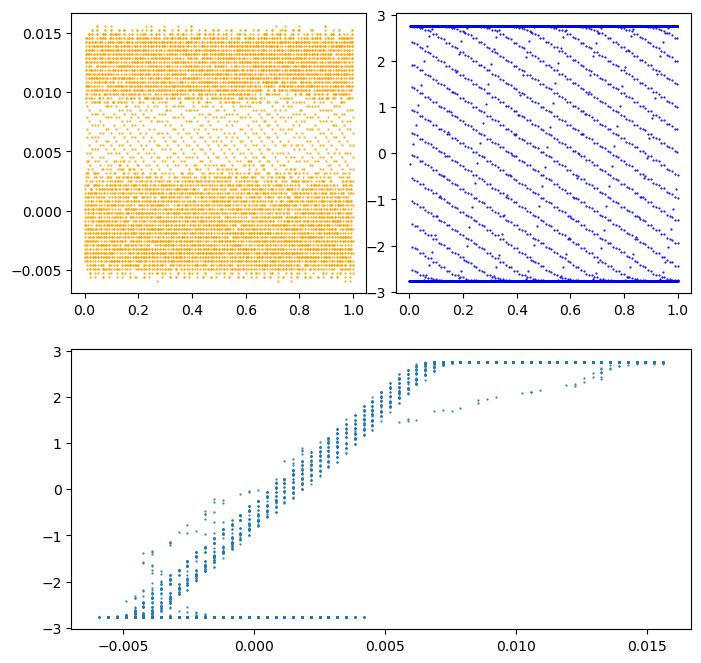

In [100]:
def sampling(time):
    hertz = 100e6
    size = time*hertz 
    if size <= 8192:
        return size,hertz
    else: 
        size = 8192
        hertz = size/time
        print(size,hertz)
        return size,int(hertz)

def config_measurement(zoroku,t_mes,Vin=5.):
    ad2.config_wavegen(zoroku, 
                frequency=10/t_mes,
                amplitude=Vin, # Vin : Voltage range to observe.
                symmetry = 100,
                signal_shape= dwfc.funcTriangle
                )
    rate,size = sampling(t_mes)
    ad2.config_oscilloscope(zoroku,
        range0=3,
        range1=3,
        sample_rate = rate,
        sample_size= size
        )
    
########## End of Function Defining ##########

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

E_sat = 15
t_mes = 0.1
size,rate = sampling(t_mes)

R1 = 10
R2 = 330
amp = -R2/R1
v_range = 1.5*E_sat*R1/R2
print(1/t_mes,amp,v_range)

config_measurement(zoroku,t_mes,v_range)

ad2.start_wavegen(zoroku,channel=0)
time.sleep(0.1)
T,Ch1,Ch2 = ad2.measure_oscilloscope(zoroku)
ad2.stop_wavegen(zoroku,channel=0)

axs1.scatter(T,Ch1,s=0.3,color="orange")
axs2.scatter(T,Ch2,s=0.3,color="blue")
axs3.scatter(Ch1,Ch2,s=0.3)

In [ ]:
from scipy.optimize import curve_fit

def linear(x,a,b):
    return a*x+b

def sampling(time):
    hertz = 100e6
    size = time*hertz 
    if size <= 8192:
        return size,hertz
    else: 
        size = 8192
        hertz = size/time
        return size,hertz

def config_measurement(zoroku,t_mes,Vin=5.):
    ad2.config_wavegen(zoroku, 
                frequency=10/t_mes,
                amplitude=Vin, # Vin : Voltage range to observe.
                symmetry = 100,
                signal_shape= dwfc.funcTriangle
                )
    rate,size = sampling(t_mes)
    ad2.config_oscilloscope(zoroku,
        range0=23,
        range1=23,
        sample_rate = rate,
        sample_size= size,
        )
    
########## End of Function Defining ##########

fig = plt.figure(figsize=(12,5))
grid = gs.GridSpec(1,2,wspace=0.1)
axs1 = plt.subplot(grid[0])
axs2 = plt.subplot(grid[1])

Res1 = 10 # in Ohms
Res2 = [150,220,330,470,510,800,1000,2000,4700]
data_dict = {"R1": Res1,"R2":Res2}

for R2 in data_dict["R2"]: 
    data_dict[R2] = "NaN"

E_sat = 5 # Bias voltage
t_mes = 0.1 # Measurement time

m_values = []
for R2 in data_dict["R2"]: 
    v_range = 1.5*E_sat*Res1/Res2
    print(v_range)
    config_measurement(zoroku,0.1,v_range)
    
    ad2.start_wavegen(zoroku,channel=0)
    time.sleep(0.1)
    T,Ch1,Ch2 = ad2.measure_oscilloscope(zoroku)
    ad2.stop_wavegen(zoroku,channel=0)
    
    data_dict[R2] = T,Ch1,Ch2
    
    handle = open("inverting_amp.pkl", 'wb')
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

    popt,_ = curve_fit(linear,Ch1,Ch2,p0=[-R2/R1,25e-6])
    X = np.linspace(-v_range,v_range)

    axs1.plot(Ch1,Ch2,label=fr"{R2}$\Omega$",alpha=0.3)
    axs1.scatter(Ch1,linear(Ch1,popt[0],popt[1]),s=0.3)
    m_values.append(popt[0])

    print("Data up to resistor %d has been collected and saved." % R2)
    input("Switch resistor, then press ENTER to measure.")

axs1.legend(loc="lower left")

m_theory = [-R2/R1 for R2 in Res2]
axs2.scatter(m_values[1:],m_theory[1:],color="red")

X = np.linspace(-5,0)
axs2.plot(X,X,color="black",alpha=0.2)

axs2.set_ylabel("Theoretical slope")
axs2.set_xlabel("Fitted slope")
fig.show()

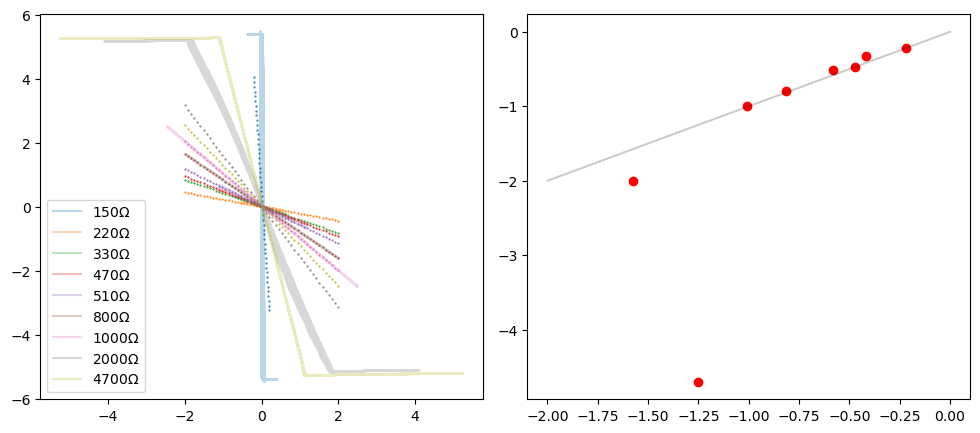

In [80]:
# Data analysis (perform on already collected pkl.)

from scipy.optimize import curve_fit

def linear(x,a,b):
    return a*x+b

########## End of Function Defining ##########

fig = plt.figure(figsize=(12,5))
grid = gs.GridSpec(1,2,wspace=0.1)
axs1 = plt.subplot(grid[0])
axs2 = plt.subplot(grid[1])

handle = open("inverting_amp.pkl", 'rb')
data=pickle.load(handle)
handle.close()

R1 = data["R1"]
Res2 = data["R2"]

m_values = []
for R2 in Res2:
    V_range = np.linspace(-2,2)
    if R2 == 150:
        V_range = np.linspace(-.2,.2)
        # continue
    
    t,Vin,Vout = data[R2]
    axs1.plot(Vin,Vout,label=fr"{R2}$\Omega$",alpha=0.3)
    
    popt,_ = curve_fit(linear,Vin,Vout,p0=[-R2/R1,25e-6])
    axs1.scatter(V_range,linear(V_range,popt[0],popt[1]),s=0.3)
    m_values.append(popt[0])
axs1.legend(loc="lower left")

# axs2.scatter(Res2[1:],m_values[1:],color="black")
m_theory = [-R2/R1 for R2 in Res2]
axs2.scatter(m_values[1:],m_theory[1:],color="red")
X = np.linspace(-2,0)
axs2.plot(X,X,color="black",alpha=0.2)